In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/daily-minimum-temperatures-in-me.csv')
df.head()

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [4]:
df.isnull().sum()

Date                          0
Daily minimum temperatures    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


In [15]:
df[df['Daily minimum temperatures'] == '?0.2']

,Date,Daily minimum temperatures
565,1982-07-20,?0.2


In [20]:
df.replace({'?0.2': 0.2, '?0.8' : 0.8, '?0.1' : 0.1}, inplace=True)

In [21]:
df['Date'] = pd.to_datetime(df['Date'])
df['Daily minimum temperatures'] = df['Daily minimum temperatures'].astype('float')

In [22]:
df.head()

,Date,Daily minimum temperatures
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


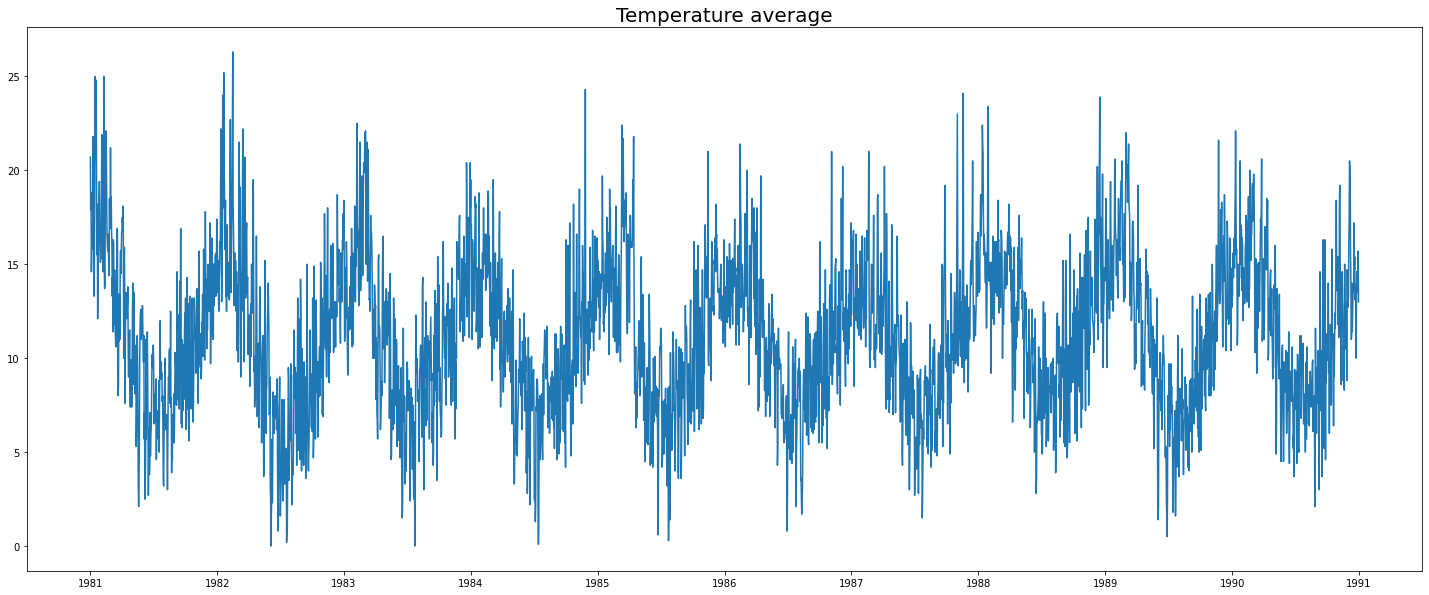

In [23]:
dates = df['Date'].values
temp  = df['Daily minimum temperatures'].values
 
 
plt.figure(figsize=(25,10))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [25]:
# membagi data test dan data train

from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(temp, test_size=0.2)

In [26]:
train_set = windowed_dataset(data_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(data_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [27]:
# Penggunaan Callbacks

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 1):
      print("\nMAE telah mencapai < 10% dari total data")
      self.model.stop_training = True
callbacks = myCallback()

In [28]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data = test_set, callbacks=[callbacks])

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 4s 133ms/step - loss: 10.4358 - mae: 10.9350 - val_loss: 10.0480 - val_mae: 10.5468
Epoch 2/100
29/29 [==============================] - 3s 110ms/step - loss: 9.7116 - mae: 10.2104 - val_loss: 9.2412 - val_mae: 9.7393
Epoch 3/100
29/29 [==============================] - 3s 109ms/step - loss: 8.9304 - mae: 9.4287 - val_loss: 8.4565 - val_mae: 8.9542
Epoch 4/100
29/29 [==============================] - 3s 108ms/step - loss: 8.0743 - mae: 8.5707 - val_lo

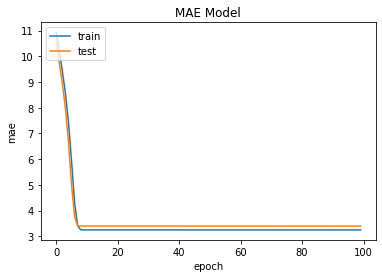

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

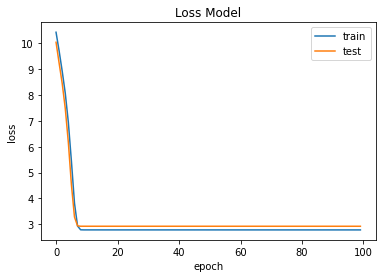

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()